<a href="https://colab.research.google.com/github/BrandonYChan/Plant-Disease-Deep_Learning/blob/main/Plant_Model_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Disease Classification Model

## Imports

In [ ]:
# Package Installation

!pip install gradio
# !pip install tensorflow==2.16.2

In [ ]:
# Imports

# Tensorflow
import tensorflow as tf, tensorflow_datasets as tfds, keras

# Data/Plots
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# Image Uploads
import os, zipfile, requests
from PIL import Image

# Testing Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report , roc_curve, roc_auc_score

# Gradio
import gradio as gr

## Dataset

In [ ]:
# Load plant_leaves Dataset (Hosted Runtime)

# # Had to build manually - Google Colab was having difficulty with tfds.load()
# dbuilder = tfds.builder('plant_leaves')
# dbuilder.download_and_prepare()
# split_ratio = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
# datasets = dbuilder.as_data_source(split=split_ratio)
# (train, validation, test), info = datasets, dbuilder.info
# print(info)

# # Convert to tensorflow dataset (loaded as array records type initially)
# def array_record_to_tf_dataset(array_record):
#     def generator():
#         for example in array_record:
#             yield example['image'], example['label']

#     return tf.data.Dataset.from_generator(
#         generator,
#         output_signature=(
#             tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
#             tf.TensorSpec(shape=(), dtype=tf.int64)
#         )
#     )

# # Convert splits to tensorflow dataset
# train = array_record_to_tf_dataset(train)
# validation = array_record_to_tf_dataset(validation)
# test = array_record_to_tf_dataset(test)

tfds.core.DatasetInfo(
    name='plant_leaves',
    full_name='plant_leaves/0.1.1',
    description="""
    This dataset consists of 4502 images of healthy and unhealthy plant leaves
    divided into 22 categories by species and state of health. The images are in
    high resolution JPG format.
    
    There are no files with label prefix 0000, therefore label encoding is shifted
    by one (e.g. file with label prefix 0001 gets encoded label 0).
    
    Note: Each image is a separate download. Some might rarely fail, therefore make
    sure to restart if that happens. An exception will be raised in case one of the
    downloads repeatedly fails.
    
    Dataset URL: https://data.mendeley.com/datasets/hb74ynkjcn/1 License:
    http://creativecommons.org/licenses/by/4.0
    """,
    homepage='https://data.mendeley.com/datasets/hb74ynkjcn/1',
    data_dir='C:\\Users\\bchan\\tensorflow_datasets\\plant_leaves\\0.1.1',
    file_format=tfrecord,
    download_size=6.56 GiB,
    dataset_siz

In [ ]:
# Load plant_leaves dataset (Local Runtime)

split_ratio = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
datasets, info = tfds.load('plant_leaves', with_info=True, split=split_ratio, as_supervised=True)
(train, validation, test) = datasets

In [ ]:
# Preprocess data


def preprocess(image, label):
  image = tf.image.resize(image, (224, 224))
  image = image / 255.0
  # Assign binary classification (0/1 for healthy/diseased)
  label = tf.where(label < 12, 0, 1)
  return image, label

# Preprocess splits with batch mapping
train = train.map(preprocess).batch(32)
validation = validation.map(preprocess).batch(32)
test = test.map(preprocess).batch(32)

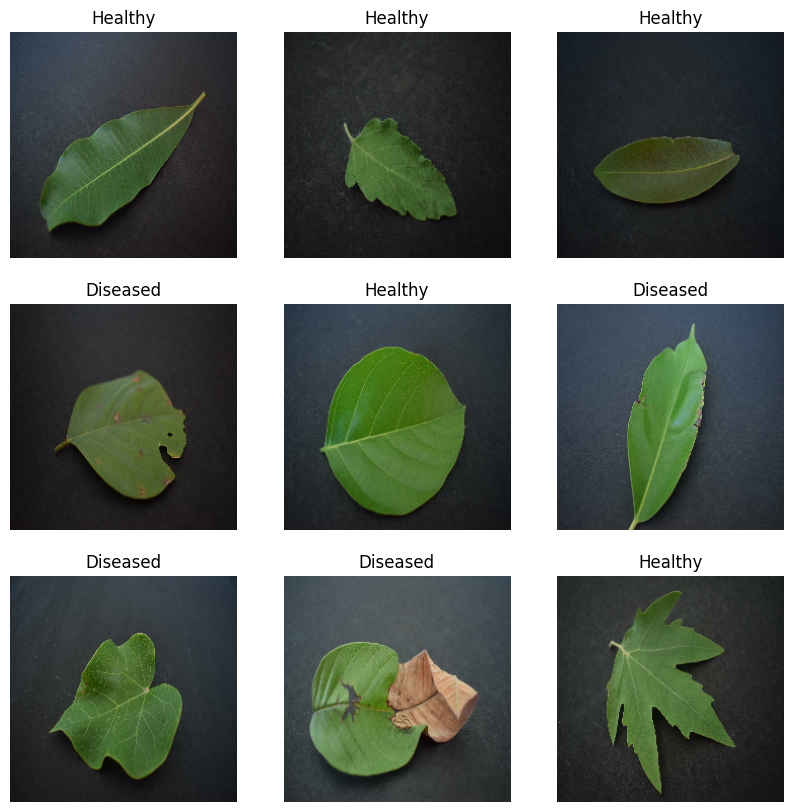

In [ ]:
# Plot Examples

def plot_images(images, img_labels):
    plt.figure(figsize=(10, 10))
    for images, labels in train.take(1):
        images = images.numpy()
        labels = labels.numpy()
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(img_labels[int(labels[i])])
            plt.axis("off")
    plt.show()


plot_images(train, ['Healthy', 'Diseased'])

## Model

In [ ]:
# Create sequential model

model = keras.Sequential()

# Add layers
model.add(keras.layers.Input(shape=(224, 224, 3)))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=128, activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile model, assign loss function and metrics
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
  )

# Train model
history = model.fit(
    train,
    epochs=10,
    validation_data=validation,
)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.6034 - loss: 0.7321 - val_accuracy: 0.6444 - val_loss: 0.6371
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7237 - loss: 0.5590 - val_accuracy: 0.6622 - val_loss: 0.6249
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7562 - loss: 0.5132 - val_accuracy: 0.7756 - val_loss: 0.4935
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.8120 - loss: 0.4196 - val_accuracy: 0.7911 - val_loss: 0.4583
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.8555 - loss: 0.3227 - val_accuracy: 0.8422 - val_loss: 0.4228
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9044 - loss: 0.2235 - val_accuracy: 0.8178 - val_loss: 0.4603
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9296 - loss: 0.1672 - val_accuracy: 0.8511 - val_loss: 0.4575
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.9462 - loss: 0.1419 - val_accu

In [ ]:
# Test accuracy

test_loss, test_accuracy = model.evaluate(test)
print(f'Test accuracy: {test_accuracy}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 648ms/step - accuracy: 0.8710 - loss: 0.3850
Test accuracy: 0.8799999952316284


## Testing and Curves

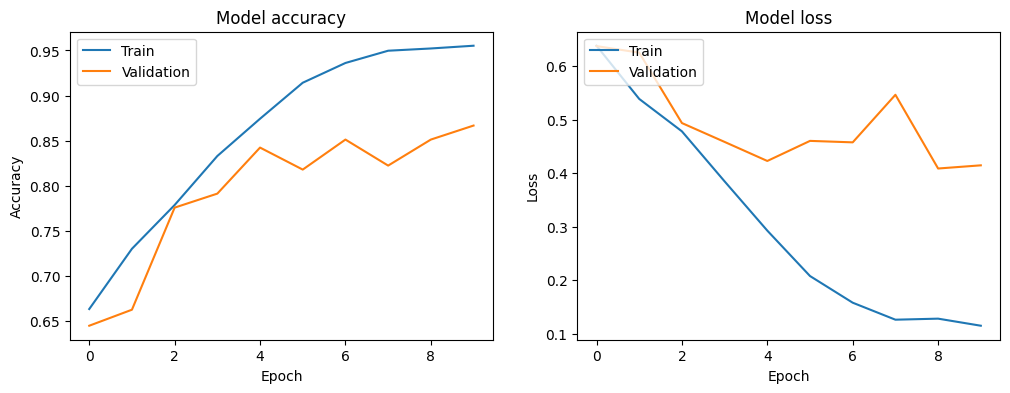

In [ ]:
# Model Accuracy and Loss During Training

plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


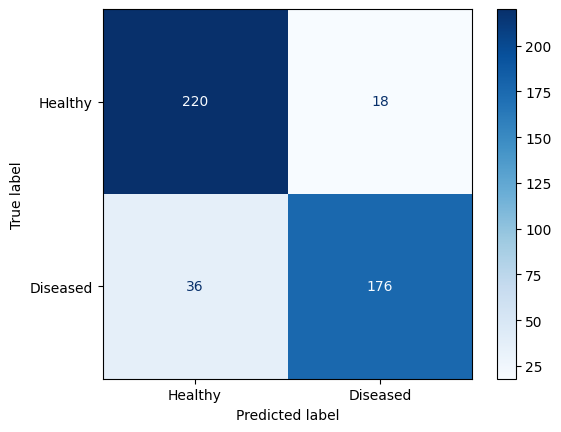

In [ ]:
# Confusion matrix

y_true = []
y_pred = []

for image, label in test:
    y_true.extend(label.numpy())
    predictions = model.predict(image)
    y_pred.extend(tf.round(predictions).numpy().flatten())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Diseased'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Classification Report

report = classification_report(y_true, y_pred, target_names=['Healthy', 'Diseased'])
print(report)

              precision    recall  f1-score   support

     Healthy       0.86      0.92      0.89       238
    Diseased       0.91      0.83      0.87       212

    accuracy                           0.88       450
   macro avg       0.88      0.88      0.88       450
weighted avg       0.88      0.88      0.88       450



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


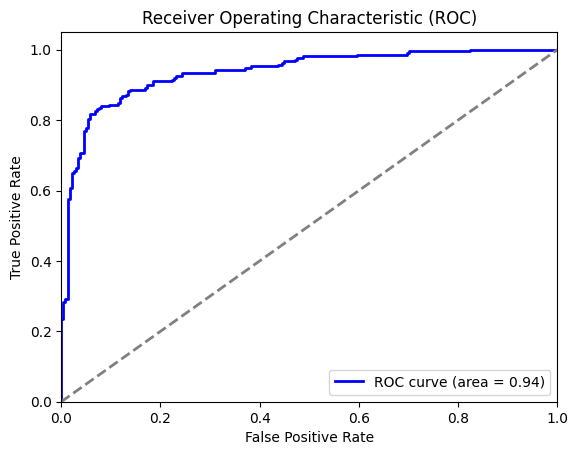

In [ ]:
# ROC and AUC

y_true = []
y_pred_prob = []

for image, label in test:
    y_true.extend(label.numpy())
    predictions = model.predict(image)
    y_pred_prob.extend(predictions.flatten())

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Gradio App

In [ ]:
# Functions for Gradio App

# Dowload image into workspace from file path or URL
def download_image(image_url, save_path='temp_image.jpg'):
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        return save_path
    else:
        print(f'Failed to download image from URL: {image_url}')
        return None

# Predict the class (diseased or healthy)
def predict_disease(image_source):
    # Check if image_source is a URL or a local path
    if image_source.startswith('http'):
        # Download the image if it's a URL
        image_path = download_image(image_source)
        if image_path is None:
            return None
    else:
        # Use the local path directly
        image_path = image_source

    # Load the image and preprocess it
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)

    # Make the prediction
    prediction = model.predict(img)
    predicted_class = (prediction > 0.5).astype("int32")[0][0]
    predicted_class = "Diseased" if predicted_class==1 else "Healthy"

    img = Image.open(image_path)
    img = img.resize((224, 224))

    plot = plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Remove the temporary file if it was downloaded
    if image_source.startswith('http'):
        os.remove(image_path)


  # Return the predicted disease
    return predicted_class, plot

In [ ]:
# Gradio App

demo = gr.Interface(
    # Function to evalutuate image from URL
    fn=predict_disease,
    # URL input
    inputs=["text"],
    # Prediction and image output
    outputs=["text", "plot"]
)
demo.launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.
